In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 

from tqdm import tqdm
from glob import glob

<h3>Initializing GPU settings</h3>

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPU number: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Available GPU number: 1


<h3>Preproccessing data</h3>

In [3]:
path_to_datasets = r'.\Forest fire'
path_to_training = os.path.join(path_to_datasets, 'Training')
path_to_testing = os.path.join(path_to_datasets, 'Testing')
path_to_validation = os.path.join(path_to_datasets, 'Validation')

<h4>Data processing function</h4>

In [4]:
def preprocessData(path):
    path_to_positive = os.path.join(path, 'fire')
    path_to_negative = os.path.join(path, 'nofire')

    images_positive = glob(path_to_positive + '/*.*')
    images_negative = glob(path_to_negative + '/*.*')

    images_list, labels_list = [], []
    for image in tqdm(images_positive):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, code=cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(1)

    for image in tqdm(images_negative):
        img = cv2.imread(image)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(0)
    
    return images_list, labels_list

<h4>Training data preparation</h4>

In [5]:
training_images_list, training_labels_list = preprocessData(path_to_training)

100%|██████████| 848/848 [00:13<00:00, 60.92it/s] 


<h4>Validation data preparation</h4>

In [6]:
validation_images_list, validation_labels_list = preprocessData(path_to_validation)

100%|██████████| 211/211 [00:01<00:00, 120.55it/s]


<h4>Testing data preparation</h4>

In [7]:
testing_images_list, testing_labels_list = preprocessData(path_to_testing)

100%|██████████| 46/46 [00:00<00:00, 195.82it/s]


<h4>Creating dataframe for all data</h4>

In [8]:
def createDataFrame(images, labels):
    dataframe = pd.DataFrame()
    dataframe['image'] = images
    dataframe['label'] = labels
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

dataframe_training = createDataFrame(training_images_list, training_labels_list)
dataframe_testing = createDataFrame(testing_images_list, testing_labels_list)
dataframe_validation = createDataFrame(validation_images_list, validation_labels_list)

In [9]:
X_train, y_train = dataframe_training['image'], dataframe_training['label']
X_test, y_test = dataframe_testing['image'], dataframe_testing['label']
X_val, y_val = dataframe_validation['image'], dataframe_validation['label']

def reshapeTensors(array_to_reshape, length):
    tensor = []
    for i in tqdm(range(length)):
        element = np.array(array_to_reshape[i].reshape(200, 200, 3))
        tensor.append(element)
    tensor = np.array(tensor)
    return tensor

X_train = reshapeTensors(X_train, X_train.shape[0]) 
X_test = reshapeTensors(X_test, X_test.shape[0]) 
X_val = reshapeTensors(X_val, X_val.shape[0]) 

100%|██████████| 497/497 [00:00<00:00, 9577.00it/s]


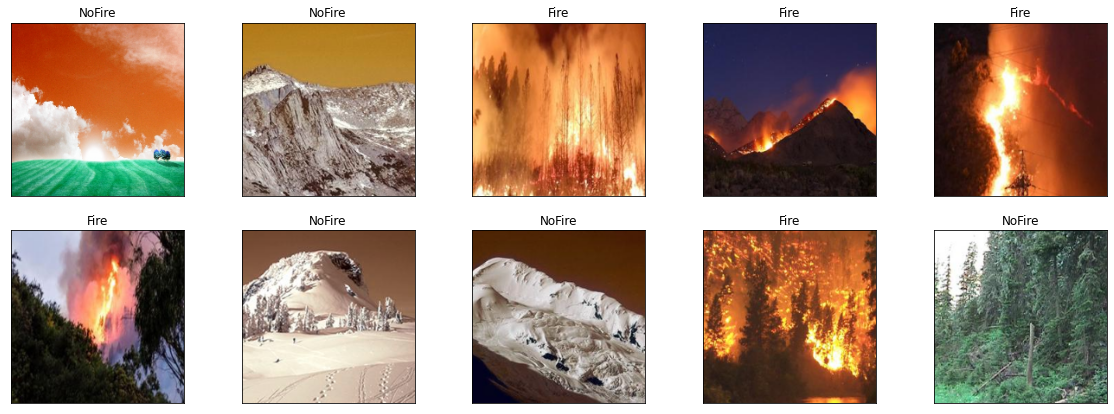

In [10]:
ind = np.random.randint(0, X_train.shape[0], 10)
i = 1
plt.figure(figsize=(20, 7))
for index in ind:
  plt.subplot(2, 5, i)
  plt.imshow(X_train[index])
  plt.title('Fire' if y_train[index] == 1 else 'NoFire')
  plt.xticks([])
  plt.yticks([])
  i += 1

<h4>Importing nessecary modules for DNN</h4>

In [11]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

<h4>Creating DNN</h4>

In [12]:
model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
output_layer = model_vgg19.layers[-1].output
output_layer = GlobalMaxPooling2D()(output_layer)
output_layer = Flatten()(output_layer)

model_vgg19 = Model(inputs=model_vgg19.input, outputs=output_layer)
model_vgg19.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

Freezing all layers of VGG19 model

In [13]:
for layer in model_vgg19.layers:
    layer.trainable = False

In [14]:
model = Sequential()
model.add(model_vgg19)
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 512)               20024384  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [16]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.0001, decay=1e-06, momentum=0.99, nesterov=True),
                 loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
54/54 [==============================] - 32s 599ms/step - loss: 3.0482 - accuracy: 0.8019 - val_loss: 1.9068 - val_accuracy: 0.9256
Epoch 2/10
54/54 [==============================] - 62s 1s/step - loss: 1.7885 - accuracy: 0.9115 - val_loss: 0.9354 - val_accuracy: 0.9396
Epoch 3/10
54/54 [==============================] - 62s 1s/step - loss: 1.5720 - accuracy: 0.9050 - val_loss: 0.8311 - val_accuracy: 0.9457
Epoch 4/10
54/54 [==============================] - 62s 1s/step - loss: 0.9330 - accuracy: 0.9349 - val_loss: 0.7659 - val_accuracy: 0.9376
Epoch 5/10
54/54 [==============================] - 63s 1s/step - loss: 0.5946 - accuracy: 0.9420 - val_loss: 1.1913 - val_accuracy: 0.9034
Epoch 6/10
54/54 [==============================] - 62s 1s/step - loss: 0.5560 - accuracy: 0.9396 - val_loss: 0.8104 - val_accuracy: 0.9135
Epoch 7/10
54/54 [==============================] - 62s 1s/step - loss: 0.4674 - accuracy: 0.9472 - val_loss: 0.3463 - val_accuracy: 0.9376
Epoch 8/10
54/54 

In [18]:
tf.keras.models.save_model(model, 'VGG19.h5')

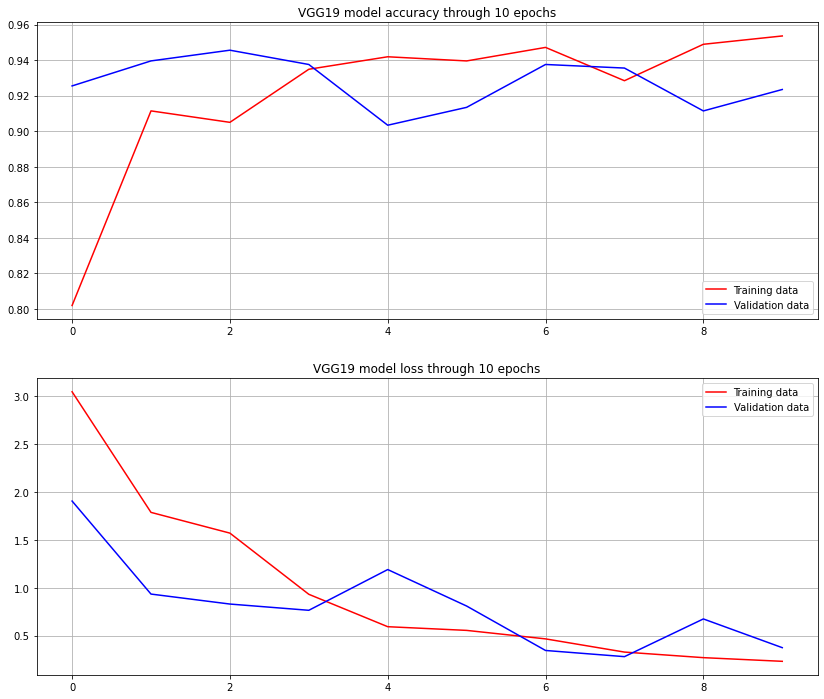

In [37]:
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(211)
ax1.set_title('VGG19 model accuracy through 10 epochs')
ax1.plot(history.history['accuracy'], color='red', label='Training data')
ax1.plot(history.history['val_accuracy'], color='blue', label='Validation data')
ax1.grid(True)
ax1.legend(loc='lower right')
ax2 = fig.add_subplot(212)
ax2.set_title('VGG19 model loss through 10 epochs')
ax2.plot(history.history['loss'], color='red', label='Training data')
ax2.plot(history.history['val_loss'], color='blue', label='Validation data')
ax2.grid(True)
ax2.legend(loc='upper right')

In [51]:
prediction = model.predict(X_test)
prediction = np.floor(prediction)
prediction = prediction.reshape(-1).astype(np.int32)
y_test = np.array(y_test)

In [ ]:
accuracy_score(y_test, prediction)

In [59]:
print(classification_report(y_test, prediction))

In [61]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', ax=ax)